# Visualize data

In [ ]:
# ! unzip ai4vn_2020.zip

In [ ]:
import pandas as pd
import glob2
import os
import matplotlib.pyplot as plt

In [ ]:
def get_path(number):
  path = "ai4vn_2020/sample_data/{}".format(number)
  _, dirs, files = next(os.walk(path))
  list_path = []
  for fn in files:
    tail = fn.split(".")[-1]
    if tail == "gif":
      print("not get ", fn)
    else:
      image_path = os.path.join(path, fn)
      list_path.append(image_path)
  
  return list_path

In [ ]:
class_1 = get_path(1)
print("len class 1: ", len(class_1))
class_1_labels = ['1']*len(class_1)

len class 1:  500


In [ ]:
class_2 = get_path(2)
print("len class 2: ", len(class_2))
class_2_labels = ['2']*len(class_2)

len class 2:  500


In [ ]:
class_3 = get_path(3)
print("len class 3: ", len(class_3))
class_3_labels = ['3']*len(class_3)

len class 3:  500


In [ ]:
class_4 = get_path(4)
print("len class 4: ", len(class_4))
class_4_labels = ['4']*len(class_4)

not get  003013.gif
not get  003021.gif
not get  003006.gif
len class 4:  497


In [ ]:
class_5 = get_path(5)
print("len class 5: ", len(class_5))
class_5_labels = ['5']*len(class_5)

not get  003579.gif
len class 5:  499


In [ ]:
class_6 = get_path(6)
print("len class 6: ", len(class_6))
class_6_labels = ['6']*len(class_6)

len class 6:  500


In [ ]:
class_7 = get_path(7)
print("len class 7: ", len(class_7))
class_7_labels = ['7']*len(class_7)

len class 7:  500


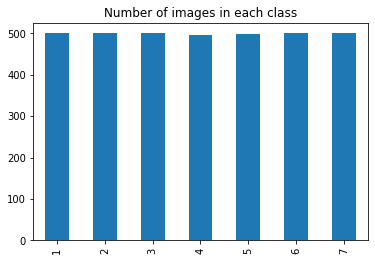

In [ ]:
labels = class_1_labels + class_2_labels + class_3_labels + class_4_labels + class_5_labels + class_6_labels + class_7_labels
image_links = class_1 + class_2 + class_3 + class_4 + class_5 + class_6 + class_7
data = pd.DataFrame({'labels': labels, 'image_links':image_links})
data.groupby(labels).image_links.count().plot.bar()
plt.title('Number of images in each class')
plt.show()

# Split data

In [ ]:
from sklearn.model_selection import train_test_split

images_train, images_val, y_label_train, y_label_val = train_test_split(image_links, labels, random_state=42, stratify = labels)

print('images_train len: {}, image_test shape: {}'.format(len(images_train), len(images_val)))

images_train len: 2622, image_test shape: 874


# Augmentated 

In [ ]:
import numpy as np
from tensorflow.keras.utils import Sequence, to_categorical
import cv2

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self,
                 all_filenames, 
                 labels, 
                 batch_size, 
                 index2class,
                 input_dim,
                 n_channels,
                 n_classes=2, 
                 normalize=True,
                 zoom_range=[0.8, 1],
                 rotation=15,
                 brightness_range=[0.8, 1],
                 shuffle=True):
        '''
        all_filenames: list toàn bộ các filename
        labels: nhãn của toàn bộ các file
        batch_size: kích thước của 1 batch
        index2class: index của các class
        input_dim: (width, height) đầu vào của ảnh
        n_channels: số lượng channels của ảnh
        n_classes: số lượng các class 
        normalize: có chuẩn hóa ảnh hay không?
        zoom_range: khoảng scale zoom là một khoảng nằm trong [0, 1].
        rotation: độ xoay ảnh.
        brightness_range: Khoảng biến thiên cường độ sáng
        shuffle: có shuffle dữ liệu sau mỗi epoch hay không?
        '''
        self.all_filenames = all_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.index2class = index2class
        self.input_dim = input_dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.normalize = normalize
        self.zoom_range = zoom_range
        self.rotation = rotation
        self.brightness_range = brightness_range
        self.on_epoch_end()

    def __len__(self):
        '''
        return:
          Trả về số lượng batch/1 epoch
        '''
        return int(np.floor(len(self.all_filenames) / self.batch_size))

    def __getitem__(self, index):
        '''
        params:
          index: index của batch
        return:
          X, y cho batch thứ index
        '''
        # Lấy ra indexes của batch thứ index
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # List all_filenames trong một batch
        all_filenames_temp = [self.all_filenames[k] for k in indexes]

        # Khởi tạo data
        X, y = self.__data_generation(all_filenames_temp)

        return X, y

    def on_epoch_end(self):
        '''
        Shuffle dữ liệu khi epochs end hoặc start.
        '''
        self.indexes = np.arange(len(self.all_filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, all_filenames_temp):
        '''
        params:
          all_filenames_temp: list các filenames trong 1 batch
        return:
          Trả về giá trị cho một batch.
        '''
        X = np.empty((self.batch_size, *self.input_dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Khởi tạo dữ liệu
        for i, fn in enumerate(all_filenames_temp):
            # Đọc file từ folder name
            img = cv2.imread(fn)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.input_dim)
            img_reshape = img.reshape(-1, 3)
            
            if self.normalize:
              mean = np.mean(img_reshape, axis=0)
              std = np.std(img_reshape, axis=0)
              img = (img-mean)/std

            if self.zoom_range:
              zoom_scale = 1/np.random.uniform(self.zoom_range[0], self.zoom_range[1])
              (h, w, c) = img.shape
              img = cv2.resize(img, (int(h*zoom_scale), int(w*zoom_scale)), interpolation = cv2.INTER_LINEAR)
              (h_rz, w_rz, c) = img.shape
              start_w = np.random.randint(0, w_rz-w) if (w_rz-w) > 0 else 0
              start_h = np.random.randint(0, h_rz-h) if (h_rz-h) > 0 else 0
              # print(start_w, start_h)
              img = img[start_h:(start_h+h), start_w:(start_w+w), :].copy()
            
            if self.rotation:
              (h, w, c) = img.shape
              angle = np.random.uniform(-self.rotation, self.rotation)
              RotMat = cv2.getRotationMatrix2D(center = (w, h), angle=angle, scale=1)
              img = cv2.warpAffine(img, RotMat, (w, h))

            if self.brightness_range:
              scale_bright = np.random.uniform(self.brightness_range[0], self.brightness_range[1])
              img = img*scale_bright
            
            # dataset_task2/data_classify/0/*.jpg
            label = fn.split("/")[-2]
            label = self.index2class[label]
            # print("label: ", label)
    
            X[i,] = img

            # Lưu class
            y[i] = label
        return X, y

dict_labels = {
    '1': 0,
    '2': 1,
    '3': 2,
    '4': 3, 
    '5': 4,
    '6': 5,
    '7': 6
}

train_generator = DataGenerator(
    all_filenames = images_train,
    labels = y_label_train,
    batch_size = 32,
    index2class = dict_labels,
    input_dim = (224, 224),
    n_channels = 3,
    n_classes = 7,
    normalize = False,
    zoom_range = [0.5, 1],
    rotation = False,
    brightness_range=[0.8, 1],
    shuffle = True
)

val_generator = DataGenerator(
    all_filenames = images_val,
    labels = y_label_val,
    batch_size = 16,
    index2class = dict_labels,
    input_dim = (224, 224),
    n_channels = 3,
    n_classes = 7,
    normalize = False,
    zoom_range = [0.5, 1],
    rotation = False,
    brightness_range =[0.8, 1],
    shuffle = False
)

#Check augment

In [ ]:
check_aug=['ai4vn_2020/sample_data/1/001999.jpg']*32

check_generator = DataGenerator(
    all_filenames = images_val,
    labels = y_label_val,
    batch_size = 20,
    index2class = dict_labels,
    input_dim = (224, 224),
    n_channels = 3,
    n_classes = 2,
    normalize = False,
    zoom_range = [0.5, 1],
    rotation = 15,
    brightness_range = [0.5, 1.5],
    shuffle = False
)

In [ ]:
X_batch, y_batch = check_generator.__getitem__(0)

print(X_batch.shape)
print(y_batch.shape)

(20, 224, 224, 3)
(20,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

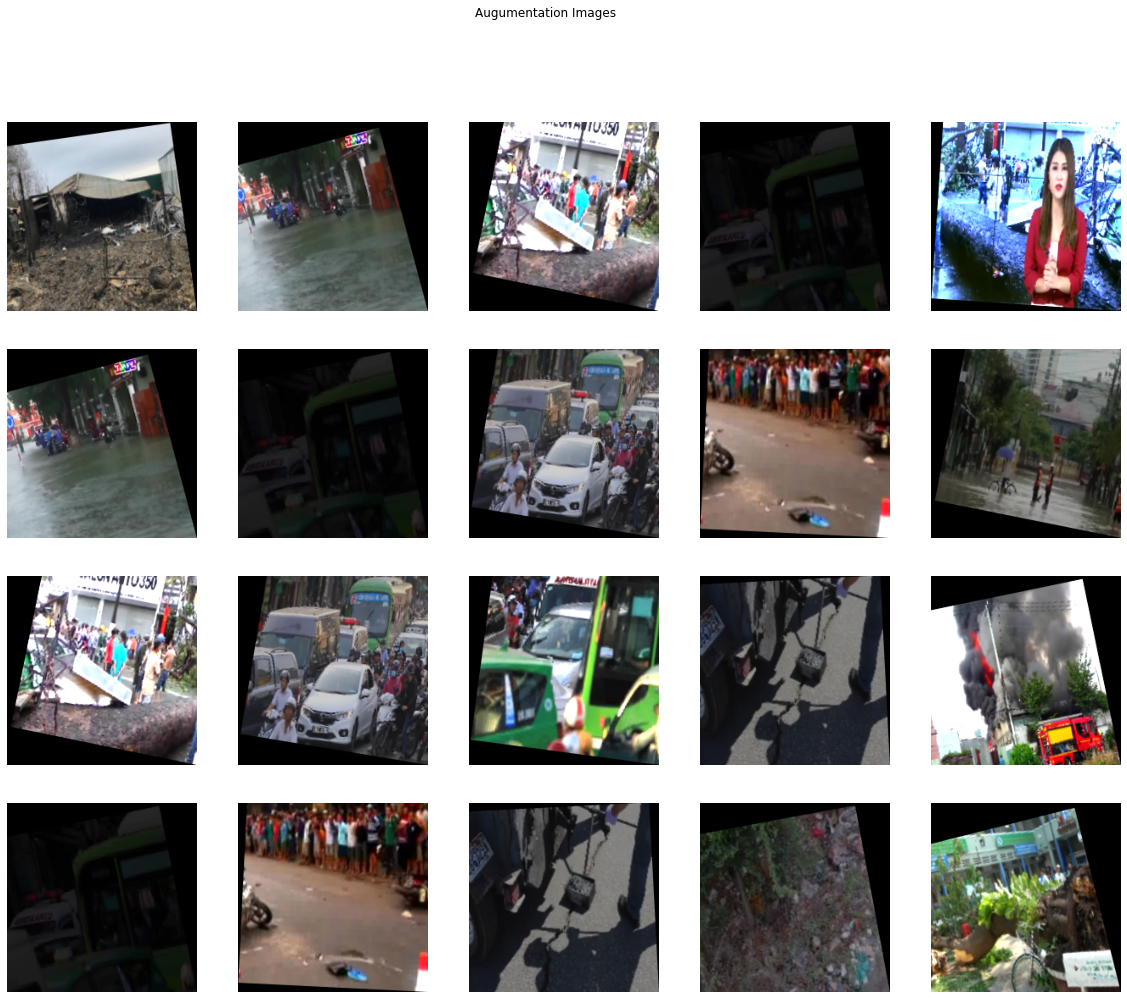

In [ ]:
import matplotlib.pyplot as plt

fg, ax = plt.subplots(4, 5, figsize=(20, 16))
fg.suptitle('Augumentation Images')

for i in np.arange(4):
  for j in np.arange(5):
    ax[i, j].imshow(X_batch[i + j + j*i]/255.0)
    ax[i, j].set_xlabel('Image '+str(i+j+j*i))
    ax[i, j].axis('off')
plt.show()

# Model


In [ ]:
from keras.applications import MobileNetV2, ResNet50, ResNet101, ResNet152
from tensorflow.keras.applications import EfficientNetB0,EfficientNetB4, EfficientNetB7
from keras.layers import Flatten, Dense, Input, Dropout, AveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
import numpy as np

In [ ]:
model = MobileNetV2(input_shape=(224, 224, 3),
                    include_top = False,
                    weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
def create_model(baseModel, number_class, lr=1e-4, decay=1e-4/25):
    for layer in baseModel.layers:
      layer.trainable = False
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(1024, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(number_class, activation="softmax")(headModel)
    
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    # compile model
    optimizer = Adam(lr=lr, decay = decay)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])    

        
    return model

In [ ]:
INIT_LR = 1e-3
EPOCHS = 50
DECAY = 1e-5
model = create_model(model, 7, lr=INIT_LR, decay=DECAY)

# Load weight

In [ ]:
# model.load_weights("my_model/mobilenet_50epoch.h5")

# Train

In [ ]:
my_checkpointer = [
                EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                ModelCheckpoint(filepath="my_model/mobilenet_50epoch.h5", verbose=2, save_weights_only=True)
                ]

history = model.fit(train_generator,
                  #  steps_per_epoch=20, 
                   validation_data= val_generator, 
                  #  validation_steps=10, 
                   epochs=EPOCHS, 
                   callbacks=my_checkpointer)

Epoch 1/50
39/81 [=============>................] - ETA: 11:03 - loss: 3.1605 - accuracy: 0.3830

# Save model

In [ ]:
model_json = model.to_json()
with open("my_model/MobileNet_recognition.json", "w") as json_file:
  json_file.write(model_json)

# Save tradeoff

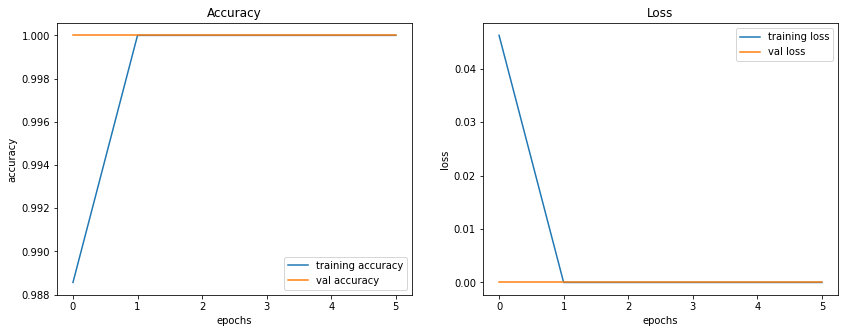

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

# Fine-tune


In [ ]:
model = MobileNetV2(input_shape=(224, 224, 3),
                    include_top = False,
                    weights='imagenet')

258080768/258076736 [==============================] - 3s 0us/step


In [ ]:
number_layer_tune = 100
def create_model(baseModel, number_class, number_layer_tune, lr=1e-4, decay=1e-4/25):
    for layer in baseModel.layers:
      layer.trainable = True
    print("Number of layers in the base model: ", len(baseModel.layers))
    # Fine-tune from this layer onwards
    fine_tune_at = number_layer_tune

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in baseModel.layers[:fine_tune_at]:
      layer.trainable =  False

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(1024, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(number_class, activation="softmax")(headModel)
    
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    # compile model
    optimizer = Adam(lr=lr/10, decay = decay)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])    

        
    return model

INIT_LR = 1e-5
# EPOCHS = 20
DECAY = 1e-5
model = create_model(model, 7, number_layer_tune, lr=INIT_LR, decay=DECAY)

Number of layers in the base model:  813


In [ ]:
model.load_weights('my_model/mobilenet_50epoch.h5')

In [ ]:
len(model.trainable_variables)

420

In [ ]:
fine_tune_epochs = 50
total_epochs = fine_tune_epochs

In [ ]:
my_checkpointer = [
                EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                ModelCheckpoint(filepath="my_model/mobilenet_tune_100epoch.h5", verbose=2, save_weights_only=True)
                ]

history = model.fit(train_generator,
                  #  steps_per_epoch=20, 
                   validation_data= val_generator, 
                  #  validation_steps=10, 
                   epochs=total_epochs, 
                   callbacks=my_checkpointer)

Epoch 1/50
60/81 [=====================>........] - ETA: 4:20 - loss: 0.6563 - accuracy: 0.7828

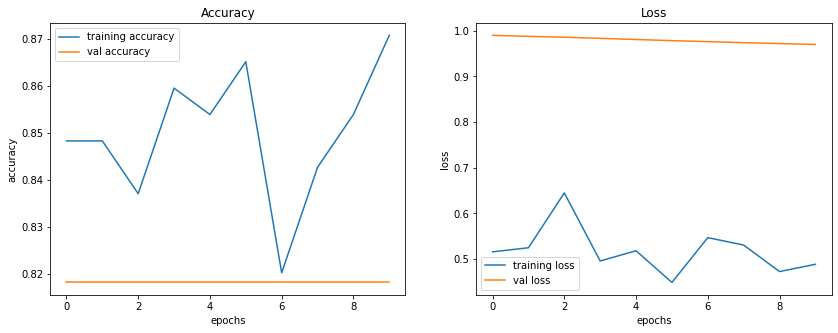

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

# Evaluate

In [ ]:
def predict(image, model, labels):
    image = cv2.resize(image, (224, 224))
    x = np.expand_dims(image, axis=0)

    result = model.predict(x, batch_size=1)
    result = labels[np.argmax(result)]

    return result

In [ ]:
with open("my_model/MobileNet_recognition.json", 'r') as json_file:
    model_json = json_file.read()

my_weight = "my_model/mobilenet_50epoch.h5"
model_loaded = model_from_json(model_json)
model_loaded.load_weights(my_weight)

In [ ]:
labels = ['1', '2', '3', '4', '5', '6', '7']
image = cv2.imread("ai4vn_2020/sample_data/1/001999.jpg")
name = predict(image, model_loaded, labels)
name

'1'

In [ ]:
for image in images_train:
  print(image)

ai4vn_2020/sample_data/1/001865.jpg
ai4vn_2020/sample_data/1/001814.jpg
ai4vn_2020/sample_data/1/001501.jpg
ai4vn_2020/sample_data/1/001685.jpg
ai4vn_2020/sample_data/1/001668.jpg
ai4vn_2020/sample_data/1/001519.jpg
ai4vn_2020/sample_data/1/001947.jpg
ai4vn_2020/sample_data/1/001835.jpg
ai4vn_2020/sample_data/1/001960.jpg
ai4vn_2020/sample_data/1/001898.jpg
ai4vn_2020/sample_data/1/001803.jpg
ai4vn_2020/sample_data/1/001870.jpg
ai4vn_2020/sample_data/1/001528.jpg
ai4vn_2020/sample_data/1/001539.jpg
ai4vn_2020/sample_data/1/001506.jpg
ai4vn_2020/sample_data/1/001691.jpg
ai4vn_2020/sample_data/1/001885.jpg
ai4vn_2020/sample_data/1/001969.jpg
ai4vn_2020/sample_data/1/001723.jpg
ai4vn_2020/sample_data/1/001569.jpg
ai4vn_2020/sample_data/1/001573.jpg
ai4vn_2020/sample_data/1/001692.jpg
ai4vn_2020/sample_data/1/001651.jpg
ai4vn_2020/sample_data/1/001791.jpg
ai4vn_2020/sample_data/1/001805.jpg
ai4vn_2020/sample_data/1/001512.jpg
ai4vn_2020/sample_data/1/001593.jpg
ai4vn_2020/sample_data/1/001

In [ ]:
y_pred = []
cnt = 0
for image_path in images_train:
  # print("image_path: ", image_path)
  my_id = image_path.split("/")[-2]
  image = cv2.imread(image_path)
  name = predict(image, model_loaded, labels)
  print("name: {}, my_id: {}".format(name, my_id))
  if name == my_id:
    cnt += 1
  y_pred.append(name)

cnt

name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, my_id: 1
name: 1, m

2625